In [5]:
from datasets import load_dataset
import torch
import joblib
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import pandas as pd

# Load the dataset
dataset = load_dataset("Amod/mental_health_counseling_conversations")

# Reload model and tokenizer for predictions
model = DistilBertForSequenceClassification.from_pretrained('/Users/pillisachethan/Desktop/NLP project/fine_tuned_distilbert')
tokenizer = DistilBertTokenizer.from_pretrained('/Users/pillisachethan/Desktop/NLP project/fine_tuned_distilbert')
label_encoder = joblib.load('/Users/pillisachethan/Desktop/NLP project/fine_tuned_distilbert/label_encoder.joblib')

# Save the mapping for labels
label_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

# Function for predictions with problem mapping
def predict_behavior_with_labels(example):
    # Tokenize and predict for 'Context'
    context_inputs = tokenizer(
        example['Context'], return_tensors="pt", truncation=True, padding=True, max_length=128
    )
    context_inputs = {key: value.to(model.device) for key, value in context_inputs.items()}
    with torch.no_grad():
        context_outputs = model(**context_inputs)
    context_logits = context_outputs.logits
    context_predicted_label = torch.argmax(context_logits, dim=1).item()
    
    # Tokenize and predict for 'Response'
    response_inputs = tokenizer(
        example['Response'], return_tensors="pt", truncation=True, padding=True, max_length=128
    )
    response_inputs = {key: value.to(model.device) for key, value in response_inputs.items()}
    with torch.no_grad():
        response_outputs = model(**response_inputs)
    response_logits = response_outputs.logits
    response_predicted_label = torch.argmax(response_logits, dim=1).item()
    
    # Add predictions to the example
    example['predicted_context'] = label_mapping[context_predicted_label]
    example['predicted_response'] = label_mapping[response_predicted_label]
    return example

# Apply the function to the dataset
dataset = dataset.map(predict_behavior_with_labels, batched=False)


In [6]:
df = dataset['train'].to_pandas()
df_selected = df[['Context', 'predicted_context', 'Response', 'predicted_response']]
df_selected.head()

,Context,predicted_context,Response,predicted_response
0,I'm going through some things with my feelings...,depression,"If everyone thinks you're worthless, then mayb...",depression
1,I'm going through some things with my feelings...,depression,"Hello, and thank you for your question and see...",depression
2,I'm going through some things with my feelings...,depression,First thing I'd suggest is getting the sleep y...,depression
3,I'm going through some things with my feelings...,depression,Therapy is essential for those that are feelin...,mentalhealth
4,I'm going through some things with my feelings...,depression,I first want to let you know that you are not ...,depression


In [7]:
df_unique = df_selected.drop_duplicates(subset=['Context'])
df_unique.head()

,Context,predicted_context,Response,predicted_response
0,I'm going through some things with my feelings...,depression,"If everyone thinks you're worthless, then mayb...",depression
23,I have so many issues to address. I have a his...,mentalhealth,Let me start by saying there are never too man...,mentalhealth
70,I have been feeling more and more down for ove...,anxiety,Answers about our inner lives are most success...,anxiety
72,I’m facing severe depression and anxiety and I...,anxiety,Have you used meditation or hypnosis? Relaxing...,adhd
81,How can I get to a place where I can be conten...,depression,Your question is a fascinating one!As humans w...,mentalhealth


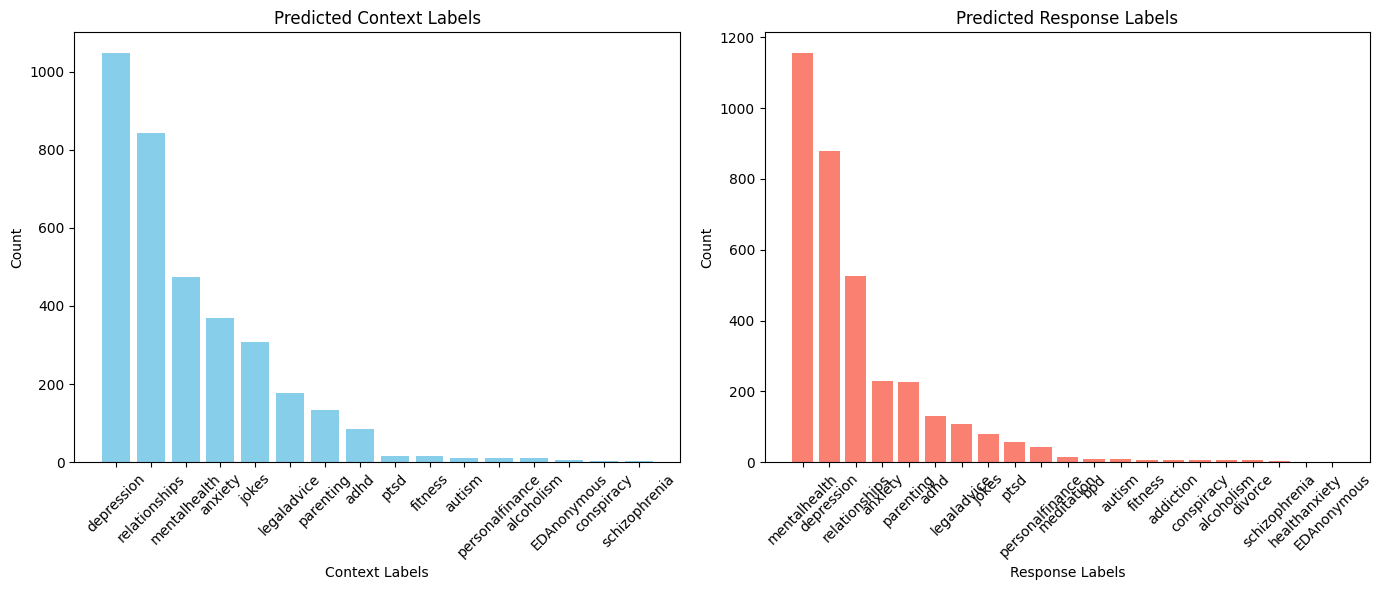

In [8]:
import matplotlib.pyplot as plt

# Count the occurrences of predicted labels for context and response
context_label_counts = df['predicted_context'].value_counts()
response_label_counts = df['predicted_response'].value_counts()

# Create subplots for context and response
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the bar chart for predicted context labels
axes[0].bar(context_label_counts.index, context_label_counts.values, color='skyblue')
axes[0].set_title('Predicted Context Labels')
axes[0].set_xlabel('Context Labels')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot the bar chart for predicted response labels
axes[1].bar(response_label_counts.index, response_label_counts.values, color='salmon')
axes[1].set_title('Predicted Response Labels')
axes[1].set_xlabel('Response Labels')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

# Show the plot
plt.tight_layout()
plt.show()